In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-12.5/nvvm/libdevice'

from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# Parâmetros (mesmos usados no preprocessing)
MAXLEN_DOC = 100
MAXLEN_SUM = 30
VOCAB_IN   = 10000
VOCAB_OUT  = 6000
BATCH_ORIG = 16384
AUTOTUNE   = tf.data.AUTOTUNE
embedding_dim = 128
units=256
# embedding_dim = 32
# units         = 64

# 1) Carregar pipelines de vetorização salvos
tv_doc = load_model("/home/olavo-dalberto/models/tv_doc_model.keras")
tv_sum = load_model("/home/olavo-dalberto/models/tv_sum_model.keras")
vocab_size_input = len(tv_doc.get_layer(index=0).get_vocabulary())
vocab_size_output = len(tv_sum.get_layer(index=0).get_vocabulary())

2025-08-03 09:21:54.397406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754223714.814956  236900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754223714.949828  236900 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754223716.995370  236900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754223716.995399  236900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754223716.995401  236900 computation_placer.cc:177] computation placer alr

In [2]:
# ENCODER LAYERS
encoder_inputs = Input(shape=(100,))
enc_emb = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim)(encoder_inputs)

encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(enc_emb)

# DECODER LAYERS
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_output, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# ATTENTION LAYERS
attention = Attention()
context_vector = attention([decoder_outputs, encoder_output])

decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, context_vector])
decoder_dense = TimeDistributed(Dense(vocab_size_output, activation='softmax'))
final_output = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], final_output)

In [3]:
ds = tf.data.Dataset.load(
    "vectorized_gigaword_ds",
    element_spec={
        'document': tf.TensorSpec((BATCH_ORIG, MAXLEN_DOC), tf.int64),
        'summary' : tf.TensorSpec((BATCH_ORIG, MAXLEN_SUM+2), tf.int64),
    }
)
# debug_raw = ds.unbatch().take(512)
# batch = next(iter(debug_raw))
batch = next(iter(ds))
print("Batch.document shape:", batch['document'].shape)  # (BATCH_ORIG, 100)
print("Batch.summary  shape:", batch['summary'].shape)   # (BATCH_ORIG, 32)

Batch.document shape: (16384, 100)
Batch.summary  shape: (16384, 32)


In [4]:
raw = ds.unbatch()
print("Single.document shape:", next(iter(raw))['document'].shape)  # (100,)
print("Single.summary  shape:", next(iter(raw))['summary'].shape)   # (32,)

Single.document shape: (100,)
Single.summary  shape: (32,)


In [5]:
VALIDATION_SPLIT = 0.2
SHUFFLE_BUFFER   = 10000

def make_training_example(x):
    enc_in = x['document']          # (100,)
    summ   = x['summary']           # (32,)
    dec_in = summ[:-1]              # (31,) remove <eos>
    dec_tr = summ[1:]               # (31,) remove <sos>
    return ((enc_in, dec_in), dec_tr)


# debug_paired = debug_raw.map(make_training_example, num_parallel_calls=AUTOTUNE)
paired = raw.map(make_training_example, num_parallel_calls=AUTOTUNE)
N = tf.data.experimental.cardinality(paired).numpy()
val_count = int(N * VALIDATION_SPLIT)
shuffled = paired.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
total = tf.data.experimental.cardinality(shuffled).numpy()


val_ds = shuffled.take(val_count).cache().batch(64).prefetch(AUTOTUNE)
train_ds = shuffled.skip(val_count).cache().batch(64).prefetch(AUTOTUNE)
# debug_ds = (
#     debug_paired
#     .shuffle(512, reshuffle_each_iteration=True)
#     .batch(32)             # batch bem pequeno
#     .prefetch(AUTOTUNE)
# )


In [7]:
for batch in train_ds.take(1):
	print(batch)

((<tf.Tensor: shape=(128, 100), dtype=int64, numpy=
array([[ 1273,   640,     7, ...,     0,     0,     0],
       [ 6186, 19183,    26, ...,     0,     0,     0],
       [    2,    24,   685, ...,     0,     0,     0],
       ...,
       [  135,   335,     6, ...,     0,     0,     0],
       [  712,    34,  2137, ...,     0,     0,     0],
       [16806,  1407,  7263, ...,     0,     0,     0]])>, <tf.Tensor: shape=(128, 31), dtype=int64, numpy=
array([[    2,  8722,  4253, ...,     0,     0,     0],
       [    2,  4343, 10992, ...,     0,     0,     0],
       [    2,    10,    43, ...,     0,     0,     0],
       ...,
       [    2,    50,  3378, ...,     0,     0,     0],
       [    2,  1442,   459, ...,     0,     0,     0],
       [    2,  2744,   903, ...,     0,     0,     0]])>), <tf.Tensor: shape=(128, 31), dtype=int64, numpy=
array([[ 8722,  4253,   569, ...,     0,     0,     0],
       [ 4343, 10992,  7138, ...,     0,     0,     0],
       [   10,    43,  1179, ...,  

2025-08-02 23:25:53.080445: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-02 23:25:53.096054: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                       reduction='none')

def masked_loss(y_true, y_pred):
    loss = loss_fn(y_true, y_pred)                   # (batch, seq_len)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=masked_loss,
    metrics=['sparse_categorical_accuracy']
)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_ds,
    epochs=30,
    #steps_per_epoch=10,
    # verbose=2,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1754223749.041206  238000 service.cc:152] XLA service 0x7030540018d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754223749.041274  238000 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
I0000 00:00:1754223750.086301  238000 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1754223750.514020  238000 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-03 09:22:42.016048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-03 09:22:44.141367: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 16 bytes spill stores, 16 bytes spill loads



47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 4.2893 - sparse_categorical_accuracy: 0.0940

2025-08-03 10:01:46.083616: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-03 10:01:46.083634: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert/data_3/_10]]
2025-08-03 10:01:46.083643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17362489797032305050
2025-08-03 10:01:46.083650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 10:01:46.083659: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 10:01:46.

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2481s 51ms/step - loss: 4.2859 - sparse_categorical_accuracy: 0.0941 - val_loss: 2.9469 - val_sparse_categorical_accuracy: 0.1303 - learning_rate: 0.0010
Epoch 2/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.8718 - sparse_categorical_accuracy: 0.1322

2025-08-03 10:42:12.084909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads

2025-08-03 10:42:23.519809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_1', 24 bytes spill stores, 24 bytes spill loads



47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 2.8718 - sparse_categorical_accuracy: 0.1322

2025-08-03 10:42:24.844189: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-08-03 10:42:24.844235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 10:42:24.844238: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 10:42:24.844243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 10:42:24.844246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 10:42:24.844250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 10:42:24.844254: I tensorflow/cor

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2438s 51ms/step - loss: 2.8716 - sparse_categorical_accuracy: 0.1322 - val_loss: 2.7957 - val_sparse_categorical_accuracy: 0.1348 - learning_rate: 0.0010
Epoch 3/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.7081 - sparse_categorical_accuracy: 0.1373

2025-08-03 11:22:41.565441: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 11:22:41.565459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 11:22:41.565463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 11:22:41.565467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 11:22:41.565470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 11:22:41.565473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 11:22:41.565476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2408s 50ms/step - loss: 2.7080 - sparse_categorical_accuracy: 0.1373 - val_loss: 2.7502 - val_sparse_categorical_accuracy: 0.1363 - learning_rate: 0.0010
Epoch 4/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.6342 - sparse_categorical_accuracy: 0.1398

2025-08-03 12:02:10.006734: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-08-03 12:02:10.006756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 12:02:10.006759: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 12:02:10.006764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 12:02:10.006768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 12:02:10.006771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 12:02:10.006775: I tensorflow/cor

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2367s 50ms/step - loss: 2.6342 - sparse_categorical_accuracy: 0.1398 - val_loss: 2.7314 - val_sparse_categorical_accuracy: 0.1369 - learning_rate: 0.0010
Epoch 5/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.5915 - sparse_categorical_accuracy: 0.1413

2025-08-03 12:41:58.128709: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 12:41:58.128732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 12:41:58.128740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 12:41:58.128747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 12:41:58.128754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 12:41:58.128762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 12:41:58.128768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2390s 50ms/step - loss: 2.5915 - sparse_categorical_accuracy: 0.1413 - val_loss: 2.7221 - val_sparse_categorical_accuracy: 0.1373 - learning_rate: 0.0010
Epoch 6/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.5638 - sparse_categorical_accuracy: 0.1423

2025-08-03 13:21:49.570577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 13:21:49.570598: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 13:21:49.570605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 13:21:49.570610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14560809008107187635
2025-08-03 13:21:49.570615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 13:21:49.570646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17362489797032305050
2025-08-03 13:21:49.570662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2391s 50ms/step - loss: 2.5638 - sparse_categorical_accuracy: 0.1423 - val_loss: 2.7176 - val_sparse_categorical_accuracy: 0.1374 - learning_rate: 0.0010
Epoch 7/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.5443 - sparse_categorical_accuracy: 0.1430 

2025-08-03 14:01:09.528927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 14:01:09.528948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 14:01:09.528955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14560809008107187635
2025-08-03 14:01:09.528961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 14:01:09.528967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17362489797032305050
2025-08-03 14:01:09.528972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13205672693760957270
2025-08-03 14:01:09.528976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2360s 49ms/step - loss: 2.5443 - sparse_categorical_accuracy: 0.1430 - val_loss: 2.7153 - val_sparse_categorical_accuracy: 0.1376 - learning_rate: 0.0010
Epoch 8/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 2.5300 - sparse_categorical_accuracy: 0.1435

2025-08-03 14:39:51.633538: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-08-03 14:39:51.633563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 14:39:51.633566: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 14:39:51.633571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 14:39:51.633575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 14:39:51.633579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 14:39:51.633583: I tensorflow/cor

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2322s 49ms/step - loss: 2.5299 - sparse_categorical_accuracy: 0.1435 - val_loss: 2.7140 - val_sparse_categorical_accuracy: 0.1377 - learning_rate: 0.0010
Epoch 9/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.5188 - sparse_categorical_accuracy: 0.1439

2025-08-03 15:19:39.505563: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 15:19:39.505586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 15:19:39.505592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 15:19:39.505598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 15:19:39.505604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 15:19:39.505609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 15:19:39.505614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2386s 50ms/step - loss: 2.5188 - sparse_categorical_accuracy: 0.1439 - val_loss: 2.7129 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 0.0010
Epoch 10/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.5099 - sparse_categorical_accuracy: 0.1443

2025-08-03 15:59:02.045907: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 15:59:02.045927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 15:59:02.045932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 15:59:02.045936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 15:59:02.045939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 15:59:02.045942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 15:59:02.045946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2363s 50ms/step - loss: 2.5099 - sparse_categorical_accuracy: 0.1443 - val_loss: 2.7124 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 0.0010
Epoch 11/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 2.5028 - sparse_categorical_accuracy: 0.1445

2025-08-03 16:37:42.778921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 16:37:42.778943: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 16:37:42.778976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 16:37:42.779031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 16:37:42.779047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 16:37:42.779054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 16:37:42.779059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2322s 49ms/step - loss: 2.5028 - sparse_categorical_accuracy: 0.1445 - val_loss: 2.7120 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 0.0010
Epoch 12/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4968 - sparse_categorical_accuracy: 0.1448

2025-08-03 17:17:14.538764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 17:17:14.538786: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 17:17:14.538795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 17:17:14.538803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 17:17:14.538811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 17:17:14.538818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 17:17:14.538826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2372s 50ms/step - loss: 2.4968 - sparse_categorical_accuracy: 0.1448 - val_loss: 2.7115 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 0.0010
Epoch 13/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4916 - sparse_categorical_accuracy: 0.1449

2025-08-03 17:57:05.466451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 17:57:05.466482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 17:57:05.466492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14560809008107187635
2025-08-03 17:57:05.466501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 17:57:05.466519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17362489797032305050
2025-08-03 17:57:05.466527: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13205672693760957270
2025-08-03 17:57:05.466532: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send i

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2391s 50ms/step - loss: 2.4916 - sparse_categorical_accuracy: 0.1449 - val_loss: 2.7113 - val_sparse_categorical_accuracy: 0.1378 - learning_rate: 0.0010
Epoch 14/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4873 - sparse_categorical_accuracy: 0.1451 

2025-08-03 18:36:07.255629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 18:36:07.255646: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 18:36:07.255652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 18:36:07.255656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 18:36:07.255660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 18:36:07.255664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 18:36:07.255668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2341s 49ms/step - loss: 2.4873 - sparse_categorical_accuracy: 0.1451 - val_loss: 2.7109 - val_sparse_categorical_accuracy: 0.1379 - learning_rate: 0.0010
Epoch 15/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4835 - sparse_categorical_accuracy: 0.1453

2025-08-03 19:15:49.074697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 19:15:49.074722: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 19:15:49.074733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 19:15:49.074741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 19:15:49.074747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 19:15:49.074752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 19:15:49.074757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2383s 50ms/step - loss: 2.4835 - sparse_categorical_accuracy: 0.1453 - val_loss: 2.7104 - val_sparse_categorical_accuracy: 0.1380 - learning_rate: 0.0010
Epoch 16/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4802 - sparse_categorical_accuracy: 0.1454

2025-08-03 19:55:50.910788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-08-03 19:55:50.910810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 19:55:50.910814: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 19:55:50.910818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 19:55:50.910822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 19:55:50.910826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 19:55:50.910830: I tensorflow/cor

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2401s 50ms/step - loss: 2.4802 - sparse_categorical_accuracy: 0.1454 - val_loss: 2.7094 - val_sparse_categorical_accuracy: 0.1380 - learning_rate: 0.0010
Epoch 17/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.4772 - sparse_categorical_accuracy: 0.1455

2025-08-03 20:35:18.089870: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 20:35:18.089888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 20:35:18.089892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 20:35:18.089896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 20:35:18.089899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 20:35:18.089902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 20:35:18.089905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2368s 50ms/step - loss: 2.4772 - sparse_categorical_accuracy: 0.1455 - val_loss: 2.7085 - val_sparse_categorical_accuracy: 0.1379 - learning_rate: 0.0010
Epoch 18/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4746 - sparse_categorical_accuracy: 0.1456

2025-08-03 21:15:11.030448: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 21:15:11.030466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 21:15:11.030471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 21:15:11.030475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14560809008107187635
2025-08-03 21:15:11.030480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 21:15:11.030484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 21:15:11.030488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2393s 50ms/step - loss: 2.4746 - sparse_categorical_accuracy: 0.1456 - val_loss: 2.7077 - val_sparse_categorical_accuracy: 0.1380 - learning_rate: 0.0010
Epoch 19/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4721 - sparse_categorical_accuracy: 0.1457

2025-08-03 21:55:07.992438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 21:55:07.992459: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 21:55:07.992469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 21:55:07.992474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 21:55:07.992481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 21:55:07.992486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 21:55:07.992493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2397s 50ms/step - loss: 2.4721 - sparse_categorical_accuracy: 0.1457 - val_loss: 2.7075 - val_sparse_categorical_accuracy: 0.1380 - learning_rate: 0.0010
Epoch 20/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4698 - sparse_categorical_accuracy: 0.1458 

2025-08-03 22:34:31.489992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 22:34:31.490014: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 22:34:31.490022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 22:34:31.490028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 22:34:31.490034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 22:34:31.490060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 22:34:31.490066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2363s 50ms/step - loss: 2.4698 - sparse_categorical_accuracy: 0.1458 - val_loss: 2.7076 - val_sparse_categorical_accuracy: 0.1380 - learning_rate: 0.0010
Epoch 21/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4677 - sparse_categorical_accuracy: 0.1459 

2025-08-03 23:13:37.195986: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 23:13:37.196004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 23:13:37.196009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 23:13:37.196013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 23:13:37.196018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 23:13:37.196021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 23:13:37.196024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2346s 49ms/step - loss: 2.4677 - sparse_categorical_accuracy: 0.1459 - val_loss: 2.7078 - val_sparse_categorical_accuracy: 0.1381 - learning_rate: 0.0010
Epoch 22/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.4657 - sparse_categorical_accuracy: 0.1459

2025-08-03 23:53:01.612079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-03 23:53:01.612099: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-03 23:53:01.612106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-03 23:53:01.612113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-03 23:53:01.612131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-03 23:53:01.612138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-03 23:53:01.612144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2364s 50ms/step - loss: 2.4657 - sparse_categorical_accuracy: 0.1459 - val_loss: 2.7065 - val_sparse_categorical_accuracy: 0.1381 - learning_rate: 0.0010
Epoch 23/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4639 - sparse_categorical_accuracy: 0.1460

2025-08-04 00:32:50.398245: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16058616346649043098
2025-08-04 00:32:50.398264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13205672693760957270
2025-08-04 00:32:50.398267: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11169917153968636994
2025-08-04 00:32:50.398271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3415547259572331962
2025-08-04 00:32:50.398274: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 00:32:50.398277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 00:32:50.398302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2389s 50ms/step - loss: 2.4639 - sparse_categorical_accuracy: 0.1460 - val_loss: 2.7058 - val_sparse_categorical_accuracy: 0.1381 - learning_rate: 0.0010
Epoch 24/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4622 - sparse_categorical_accuracy: 0.1461

2025-08-04 01:12:25.269982: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 01:12:25.270004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 01:12:25.270009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 01:12:25.270014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 01:12:25.270018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 01:12:25.270023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-04 01:12:25.270027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2375s 50ms/step - loss: 2.4622 - sparse_categorical_accuracy: 0.1461 - val_loss: 2.7057 - val_sparse_categorical_accuracy: 0.1381 - learning_rate: 0.0010
Epoch 25/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.4606 - sparse_categorical_accuracy: 0.1461

2025-08-04 01:51:44.683032: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 01:51:44.683053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 01:51:44.683058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 01:51:44.683062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 01:51:44.683066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 01:51:44.683070: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-04 01:51:44.683074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2360s 49ms/step - loss: 2.4606 - sparse_categorical_accuracy: 0.1461 - val_loss: 2.7052 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010
Epoch 26/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4591 - sparse_categorical_accuracy: 0.1462 

2025-08-04 02:30:59.123896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 02:30:59.123916: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 02:30:59.123922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 02:30:59.123927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 02:30:59.123932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 02:30:59.123936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14560809008107187635
2025-08-04 02:30:59.123941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2355s 49ms/step - loss: 2.4591 - sparse_categorical_accuracy: 0.1462 - val_loss: 2.7047 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010
Epoch 27/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 2.4578 - sparse_categorical_accuracy: 0.1462

2025-08-04 03:10:38.396594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 03:10:38.396628: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 03:10:38.396636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 03:10:38.396642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 03:10:38.396648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 03:10:38.396652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-04 03:10:38.396656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2379s 50ms/step - loss: 2.4578 - sparse_categorical_accuracy: 0.1462 - val_loss: 2.7043 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010
Epoch 28/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4563 - sparse_categorical_accuracy: 0.1463 

2025-08-04 03:49:43.975510: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 03:49:43.975528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 03:49:43.975533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 03:49:43.975537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 03:49:43.975542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 03:49:43.975545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-04 03:49:43.975549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2346s 49ms/step - loss: 2.4563 - sparse_categorical_accuracy: 0.1463 - val_loss: 2.7042 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010
Epoch 29/30
47508/47719 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4552 - sparse_categorical_accuracy: 0.1463 

2025-08-04 04:28:52.696531: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16058616346649043098
2025-08-04 04:28:52.696558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17362489797032305050
2025-08-04 04:28:52.696570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13205672693760957270
2025-08-04 04:28:52.696575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 04:28:52.696592: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 04:28:52.696596: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11169917153968636994
2025-08-04 04:28:52.696601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous rec

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2348s 49ms/step - loss: 2.4552 - sparse_categorical_accuracy: 0.1463 - val_loss: 2.7042 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010
Epoch 30/30
47507/47719 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 2.4538 - sparse_categorical_accuracy: 0.1464

2025-08-04 05:08:15.016575: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11205808568531276363
2025-08-04 05:08:15.016594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6017271411481260721
2025-08-04 05:08:15.016598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 209703165076108331
2025-08-04 05:08:15.016602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3298193932251162611
2025-08-04 05:08:15.016606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10406326558101294011
2025-08-04 05:08:15.016609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2715499535751355505
2025-08-04 05:08:15.016612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

47719/47719 ━━━━━━━━━━━━━━━━━━━━ 2363s 50ms/step - loss: 2.4538 - sparse_categorical_accuracy: 0.1464 - val_loss: 2.7036 - val_sparse_categorical_accuracy: 0.1382 - learning_rate: 0.0010


In [ ]:
# debug_val = debug_paired.skip(512).take(128).batch(16)

# model.fit(
#     debug_ds,
#     validation_data=debug_val,
#     epochs=30,
#     steps_per_epoch=10,
#     validation_steps=5,
# )

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.9508 - sparse_categorical_accuracy: 0.0468
Epoch 2/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.9228 - sparse_categorical_accuracy: 0.0497

2025-08-02 23:07:19.683179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:19.683215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:19.683235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:19.683243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:19.683277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.9586 - sparse_categorical_accuracy: 0.0506
Epoch 3/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 4.9186 - sparse_categorical_accuracy: 0.0554

2025-08-02 23:07:20.070016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:20.070037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:20.070045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:20.070052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:20.070074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.7918 - sparse_categorical_accuracy: 0.0509
Epoch 4/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.9254 - sparse_categorical_accuracy: 0.0508

2025-08-02 23:07:20.739256: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-02 23:07:20.739288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:20.739294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:20.739300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:20.739307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:20.739328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9766 - sparse_categorical_accuracy: 0.0490
Epoch 5/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 4.7346 - sparse_categorical_accuracy: 0.0494

2025-08-02 23:07:21.133766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:21.133788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:21.133796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:21.133804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:21.133830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.7445 - sparse_categorical_accuracy: 0.0510
Epoch 6/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9151 - sparse_categorical_accuracy: 0.0454

2025-08-02 23:07:21.800509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:21.800529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:21.800536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:21.800542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:21.800563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.8524 - sparse_categorical_accuracy: 0.0493
Epoch 7/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 4.6581 - sparse_categorical_accuracy: 0.0534

2025-08-02 23:07:22.188912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:22.188943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:22.188953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:22.188960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:22.188984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.6153 - sparse_categorical_accuracy: 0.0525
Epoch 8/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.6821 - sparse_categorical_accuracy: 0.0520

2025-08-02 23:07:22.874076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:22.874096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:22.874103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:22.874109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:22.874128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.7039 - sparse_categorical_accuracy: 0.0513
Epoch 9/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 4.3271 - sparse_categorical_accuracy: 0.0625

2025-08-02 23:07:23.259730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:23.259761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:23.259771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:23.259778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:23.259806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.4682 - sparse_categorical_accuracy: 0.0568
Epoch 10/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5821 - sparse_categorical_accuracy: 0.0444

2025-08-02 23:07:23.939523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:23.939545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:23.939553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:23.939560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:23.939581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.6474 - sparse_categorical_accuracy: 0.0455
Epoch 11/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 4.4454 - sparse_categorical_accuracy: 0.0534

2025-08-02 23:07:24.273611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:24.273634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:24.273641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:24.273647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:24.273670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.4338 - sparse_categorical_accuracy: 0.0525
Epoch 12/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5351 - sparse_categorical_accuracy: 0.0545

2025-08-02 23:07:24.953983: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-02 23:07:24.954017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:24.954025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:24.954031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:24.954040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:24.954061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.5211 - sparse_categorical_accuracy: 0.0534
Epoch 13/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 4.2844 - sparse_categorical_accuracy: 0.0635

2025-08-02 23:07:25.336415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:25.336437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:25.336446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:25.336452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:25.336474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.2987 - sparse_categorical_accuracy: 0.0577
Epoch 14/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3722 - sparse_categorical_accuracy: 0.0551

2025-08-02 23:07:26.010260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:26.010279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:26.010286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:26.010292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:26.010311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.4274 - sparse_categorical_accuracy: 0.0539
Epoch 15/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 4.1704 - sparse_categorical_accuracy: 0.0544

2025-08-02 23:07:26.420719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:26.420753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:26.420769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:26.420780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:26.420812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.2059 - sparse_categorical_accuracy: 0.0567
Epoch 16/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3605 - sparse_categorical_accuracy: 0.0536

2025-08-02 23:07:27.102529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:27.102558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:27.102569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:27.102577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:27.102609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.3551 - sparse_categorical_accuracy: 0.0559
Epoch 17/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 4.1016 - sparse_categorical_accuracy: 0.0575

2025-08-02 23:07:27.483854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:27.483876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:27.483884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:27.483892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:27.483914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.1130 - sparse_categorical_accuracy: 0.0600
Epoch 18/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.2282 - sparse_categorical_accuracy: 0.0640

2025-08-02 23:07:28.164819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:28.164841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:28.164850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:28.164857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:28.164878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.2656 - sparse_categorical_accuracy: 0.0610
Epoch 19/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 4.1038 - sparse_categorical_accuracy: 0.0595

2025-08-02 23:07:28.537474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:28.537496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:28.537505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:28.537511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:28.537533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.0671 - sparse_categorical_accuracy: 0.0598
Epoch 20/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.1880 - sparse_categorical_accuracy: 0.0553

2025-08-02 23:07:29.215889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:29.215920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:29.215931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:29.215938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:29.215970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.1891 - sparse_categorical_accuracy: 0.0587
Epoch 21/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 3.9288 - sparse_categorical_accuracy: 0.0716

2025-08-02 23:07:29.600096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:29.600119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:29.600128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:29.600135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:29.600159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.9660 - sparse_categorical_accuracy: 0.0655
Epoch 22/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1448 - sparse_categorical_accuracy: 0.0600

2025-08-02 23:07:30.262855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:30.262877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:30.262887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:30.262896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:30.262920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.1442 - sparse_categorical_accuracy: 0.0594
Epoch 23/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 3.8054 - sparse_categorical_accuracy: 0.0746

2025-08-02 23:07:30.644365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:30.644387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:30.644396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:30.644402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:30.644424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.9034 - sparse_categorical_accuracy: 0.0673
Epoch 24/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9919 - sparse_categorical_accuracy: 0.0649

2025-08-02 23:07:31.324102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:31.324124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:31.324132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:31.324139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:31.324159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.0644 - sparse_categorical_accuracy: 0.0622
Epoch 25/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 3.9262 - sparse_categorical_accuracy: 0.0645

2025-08-02 23:07:31.713355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:31.713375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:31.713383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:31.713390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:31.713411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.8787 - sparse_categorical_accuracy: 0.0666
Epoch 26/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9245 - sparse_categorical_accuracy: 0.0621

2025-08-02 23:07:32.374616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:32.374638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:32.374645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:32.374652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:32.374675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.9745 - sparse_categorical_accuracy: 0.0620
Epoch 27/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 3.8951 - sparse_categorical_accuracy: 0.0696

2025-08-02 23:07:32.745844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:32.745863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:32.745869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:32.745874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:32.745892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.8033 - sparse_categorical_accuracy: 0.0711
Epoch 28/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.8268 - sparse_categorical_accuracy: 0.0679

2025-08-02 23:07:33.428827: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-02 23:07:33.428858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:33.428864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:33.428871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:33.428877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:33.428898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.8809 - sparse_categorical_accuracy: 0.0657
Epoch 29/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 3.6946 - sparse_categorical_accuracy: 0.0837

2025-08-02 23:07:33.838541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:33.838575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:33.838586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:33.838596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:33.838628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.6581 - sparse_categorical_accuracy: 0.0787
Epoch 30/30
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7683 - sparse_categorical_accuracy: 0.0715

2025-08-02 23:07:34.514836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:34.514858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:34.514866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:34.514873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:34.514895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.8106 - sparse_categorical_accuracy: 0.0682


2025-08-02 23:07:34.904210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1081768004090644575
2025-08-02 23:07:34.904268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5204528839323699281
2025-08-02 23:07:34.904282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14949832453985974469
2025-08-02 23:07:34.904290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 733256767767716498
2025-08-02 23:07:34.904312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8475208587743472188


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,536,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100,      │    394,240 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 256) │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  6,156,000 │ concatenate[0][0] │
│ (TimeDistributed)   │ 12000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,121,446 (126.35 MB)

 Trainable params: 11,040,480 (42.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,080,966 (84.23 MB)

In [10]:
import numpy as np

vocab_doc = np.load("/home/olavo-dalberto/models/vocab_doc.npy", allow_pickle=True)
vocab_sum = np.load("/home/olavo-dalberto/models/vocab_sum.npy", allow_pickle=True)
tv_doc = tf.keras.models.load_model("/home/olavo-dalberto/models/tv_doc_model.keras")
tv_sum = tf.keras.models.load_model("/home/olavo-dalberto/models/tv_sum_model.keras")

In [11]:
vocab_sum

array(['', '[UNK]', 'sos', ..., 'likud', 'lacks', 'hat'], dtype='<U18')

In [11]:
# ENCODER MODEL

# 1. Inputs
encoder_inputs = model.input[0]  # equivale a layer 0

# 2. Camadas do encoder
enc_emb_layer = model.get_layer(index=2)  # index 2
enc_lstm_layer = model.get_layer(index=4)      # index 4

# 3. Reconstrói fluxo
enc_emb = enc_emb_layer(encoder_inputs)
encoder_outputs, state_h_enc, state_c_enc = enc_lstm_layer(enc_emb)

# 4. Cria o model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h_enc, state_c_enc]
)

# DECODER MODEL


# Parâmetros
units = enc_lstm_layer.units
vocab_size_output = model.get_layer(index=3).input_dim

# 1. Inputs de inference
decoder_input_token = Input(shape=(1,),            name='decoder_input')     # one token
decoder_state_h_in  = Input(shape=(units,),        name='decoder_state_h')
decoder_state_c_in  = Input(shape=(units,),        name='decoder_state_c')
encoder_outputs_in  = Input(shape=(None, units),    name='encoder_outputs')

# 2. Camadas do decoder (reutilizando pesos)
dec_emb_layer  = model.get_layer(index=3)     # index 3
dec_lstm_layer = model.get_layer(index=5)          # index 5
attn_layer     = model.get_layer(index=6)       # index 6
concat_layer   = model.get_layer(index=7)     # index 7
proj_layer     = model.get_layer(index=8)# index 8

# 3. Fluxo passo‑a‑passo
dec_emb_inf = dec_emb_layer(decoder_input_token)  
dec_outs, state_h_dec, state_c_dec = dec_lstm_layer(
    dec_emb_inf, initial_state=[decoder_state_h_in, decoder_state_c_in]
)
context_vector = attn_layer([dec_outs, encoder_outputs_in])
dec_concat = concat_layer([dec_outs, context_vector])
dec_logits = proj_layer(dec_concat)

# 4. Modelo de inference do decoder
decoder_model = Model(
    inputs=[decoder_input_token, encoder_outputs_in, decoder_state_h_in, decoder_state_c_in],
    outputs=[dec_logits, state_h_dec, state_c_dec]
)

In [12]:
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 100, 256),     │       394,240 │
│                                 │ (None, 256), (None,    │               │
│                                 │ 256)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954,240 (11.27 MB)

 Trainable params: 2,954,240 (11.27 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 128)    │  1,536,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_state_h     │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_state_c     │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 256),  │    394,240 │ embedding_1[1][0… │
│                     │ (None, 256),      │            │ decoder_state_h[… │
│                     │ (None, 256)]      │            │ decoder_state_c[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, None, 256) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 256)    │          0 │ lstm_1[1][0],     │
│ (Attention)         │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 512)    │          0 │ lstm_1[1][0],     │
│ (Concatenate)       │                   │            │ attention[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 12000)  │  6,156,000 │ concatenate[1][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,086,240 (30.85 MB)

 Trainable params: 8,086,240 (30.85 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# import numpy as np

# # 1) Acha os índices de <sos> e <eos>
sum_vocab = tv_sum.get_layer(index=0).get_vocabulary()
sos_id = sum_vocab.index('sos')
eos_id = sum_vocab.index('eos')

# def decode_sequence(raw_text, max_len=MAXLEN_SUM+2):
#     # 1) Vetoriza o documento
#     doc_input = tf.constant([[raw_text]], dtype=tf.string)  # shape (1,1)
#     doc_vector = tv_doc.predict(doc_input, verbose=0)       # (1, MAXLEN_DOC)

#     # 2) Passa pelo encoder
#     enc_outs, h, c = encoder_model.predict(doc_vector, verbose=0)

#     # 3) Inicia o decoder com <sos>
#     target_seq = np.array([[sos_id]], dtype=np.int32)
#     decoded_ids = []

#     # 4) Geração de tokens
#     for _ in range(max_len):
#         logits, h, c = decoder_model.predict([target_seq, enc_outs, h, c], verbose=0)
#         next_id = int(np.argmax(logits[0, -1, :]))

#         # Se <eos>, param o loop
#         if next_id == eos_id:
#             break

#         # Atualiza o target_seq para o próximo passo
#         target_seq = np.array([[next_id]], dtype=np.int32)

#         # Só adiciona se for um token real (> eos_id)
#         if next_id > eos_id:
#             decoded_ids.append(next_id)

#     # 5) Converte índices em tokens (pulando PAD/UNK)
#     decoded_tokens = []
#     for idx in decoded_ids:
#         token = sum_vocab[idx]
#         if token in ['', '[UNK]']:
#             continue
#         decoded_tokens.append(token)

#     return ' '.join(decoded_tokens)

In [15]:
import tensorflow as tf

def sample_with_temperature(logits, temperature=1.5):
    # logits: array shape (vocab,)
    probs = tf.nn.softmax(logits / temperature).numpy()
    return np.random.choice(len(probs), p=probs)

def decode_with_sampling(raw_text, temperature=1.5, max_len=MAXLEN_SUM+2):
    doc_input  = tf.constant([[raw_text]])
    doc_vector = tv_doc.predict(doc_input, verbose=0)
    enc_outs, h, c = encoder_model.predict(doc_vector, verbose=0)

    sos_id = sum_vocab.index('sos')
    eos_id = sum_vocab.index('eos')
    target_seq = np.array([[sos_id]], dtype=np.int32)
    decoded_ids = []

    for step in range(max_len):
        logits, h, c = decoder_model.predict([target_seq, enc_outs, h, c], verbose=0)
        next_id = sample_with_temperature(logits[0,0,:], temperature)
        if next_id == eos_id:
            break
        decoded_ids.append(next_id)
        target_seq = np.array([[next_id]], dtype=np.int32)

    return [sum_vocab[i] for i in decoded_ids if i > eos_id]

In [18]:
# print(decode_sequence("Este é um texto de teste para sumarização."))
raw_text = """The government said Monday it has concluded  
talks with the Walt Disney Co. about building a theme park here, 
and an official said the two sides had reached a deal.
</P>"""

' '.join(decode_with_sampling(raw_text))

'grilled ilo breakaway waste nalbandian author jon soviet organizing sore national faster runup drugs hotels builder uranium resurgence boat chen garbage wheel wesley analysts civilian editor cyprus dossier kenya obligations incursion existing'

In [26]:
import numpy as np

lengths = []
for example in debug_raw:
    summ_vec = example['summary'].numpy()
    eos_pos = np.where(summ_vec == sum_vocab.index('eos'))[0]
    if len(eos_pos):
        lengths.append(eos_pos[0])
    else:
        lengths.append(len(summ_vec))

print("Resumos com eos na posição 1:", sum(np.array(lengths)==1), "/", len(lengths))
print("Distribuição de lengths:", np.bincount(lengths)[:10])

Resumos com eos na posição 1: 0 / 512
Distribuição de lengths: [ 0  0  0  0  2 22 59 84 83 78]


In [21]:
decode_sequence("This is a text for summarization.")

''

In [39]:
# Se tv_sum for um Model, o layer de Vectorization é o segundo:
vec_layer = tv_sum.layers[0]
# Pega a lista de tokens
sum_vocab = vec_layer.get_vocabulary()

# Veja os primeiros 20 tokens
for idx, token in enumerate(sum_vocab[:20]):
    print(idx, repr(token))


0 ''
1 '[UNK]'
2 'sos'
3 'eos'
4 'to'
5 'in'
6 'of'
7 'for'
8 's'
9 'on'
10 'us'
11 'unk'
12 'with'
13 'at'
14 'says'
15 'new'
16 'china'
17 'as'
18 'the'
19 'a'


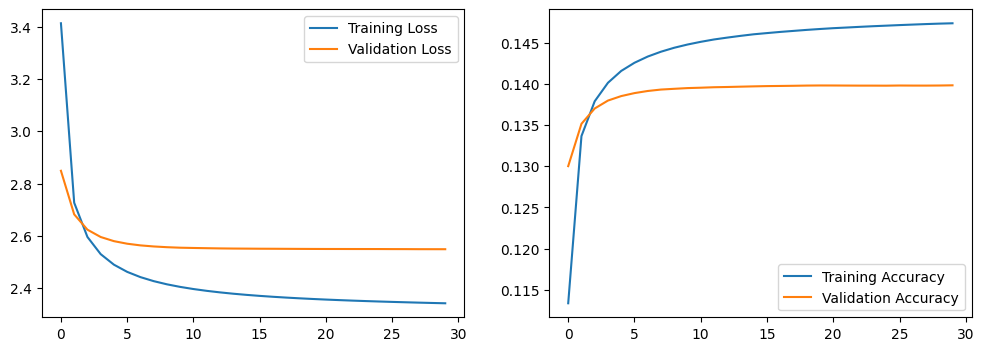

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()